In [17]:
import requests
import urllib.request as req
import json
from pandas.io.json import json_normalize
from datetime import datetime, timedelta
import time
import re
def getjson(url):
    response = requests.get(url)
    response = response.json()
    return response




Интересующая начальна дата выгрузки - март 2020 год. К апрелю 2020 объявили карантин, что очевидно приведет к увеличению числа студентов (можно сравнить как повлияет карантин на прирост аудитории паблика, а также посмотреть как она росла или убывала в разные сезоны года). Для этого нужно определить начальную дату выгрузки.

In [14]:
vk_token = '2fc107518f367f650ae9ae7154d7e13f936da6408c8cdc61a114f52664ce85ea8821baf865b85f22d3187'

dt = datetime.strptime('2020-03-01 02:17:59','%Y-%m-%d %H:%M:%S')
stamp = int(time.mktime(dt.timetuple()))

offset = 0
min_date = 1612688864
data = pd.DataFrame()
url = 'https://api.vk.com/method/wall.get?access_token=' + str(vk_token) + '&owner_id=-66669811&count=100&v=5.92'
while min_date >= stamp:
    response = getjson(url)
    df = pd.json_normalize(response, ['response','items'])
    data = data.append(df)
    min_date = df['date'].min()
    offset += 100
    url = 'https://api.vk.com/method/wall.get?access_token=' + str(vk_token) + '&owner_id=-66669811&offset=' + str(offset) + '&count=100&v=5.92'

In [15]:
#Преобразование датафрейма для анализа 
df = data[['id', 'date', 'text', 'comments.count', 'likes.count', 'reposts.count', 'views.count']]
recolumn = {
    'comments.count':'Number of comments',
    'likes.count': 'Number of Likes',
    'reposts.count': 'Number of Reposts',
    'views.count': 'Number of Views'}
df = df.rename(columns=recolumn)
df['date'] = df['date'].apply(lambda x: (datetime.fromtimestamp(x) - timedelta(hours=0)))
df['month_year'] = df['date'].apply(lambda x: x.strftime('%Y') + '-' + x.strftime('%m'))
df['day_of_week'] = df['date'].apply(lambda x: x.strftime('%A'))
df['day_of_week_num'] = df['date'].apply(lambda x: x.strftime('%w'))
df.head()

,id,date,text,Number of comments,Number of Likes,Number of Reposts,Number of Views,month_year,day_of_week,day_of_week_num
0,147794,2021-02-09 21:32:41,Учиться на своих ошибках — хорошо. А еще лучше...,5,28,25,5339,2021-02,Tuesday,2
1,147695,2021-02-09 01:42:33,"Оказывается, 75% времени при создании программ...",0,29,14,11202,2021-02,Tuesday,2
2,147680,2021-02-08 22:39:20,9 февраля в 19:00 состоится открытое интервью...,8,21,1,12218,2021-02,Monday,1
3,147581,2021-02-08 19:05:24,Привет! На этой неделе расскажем о тонкостях п...,1,31,23,13397,2021-02,Monday,1
4,147469,2021-02-07 19:07:44,"Кадры, от которых сильнее бьется сердце.\n\nФо...",9,208,68,34325,2021-02,Sunday,0


Ниже представлен анализ между временем и параметрами поста

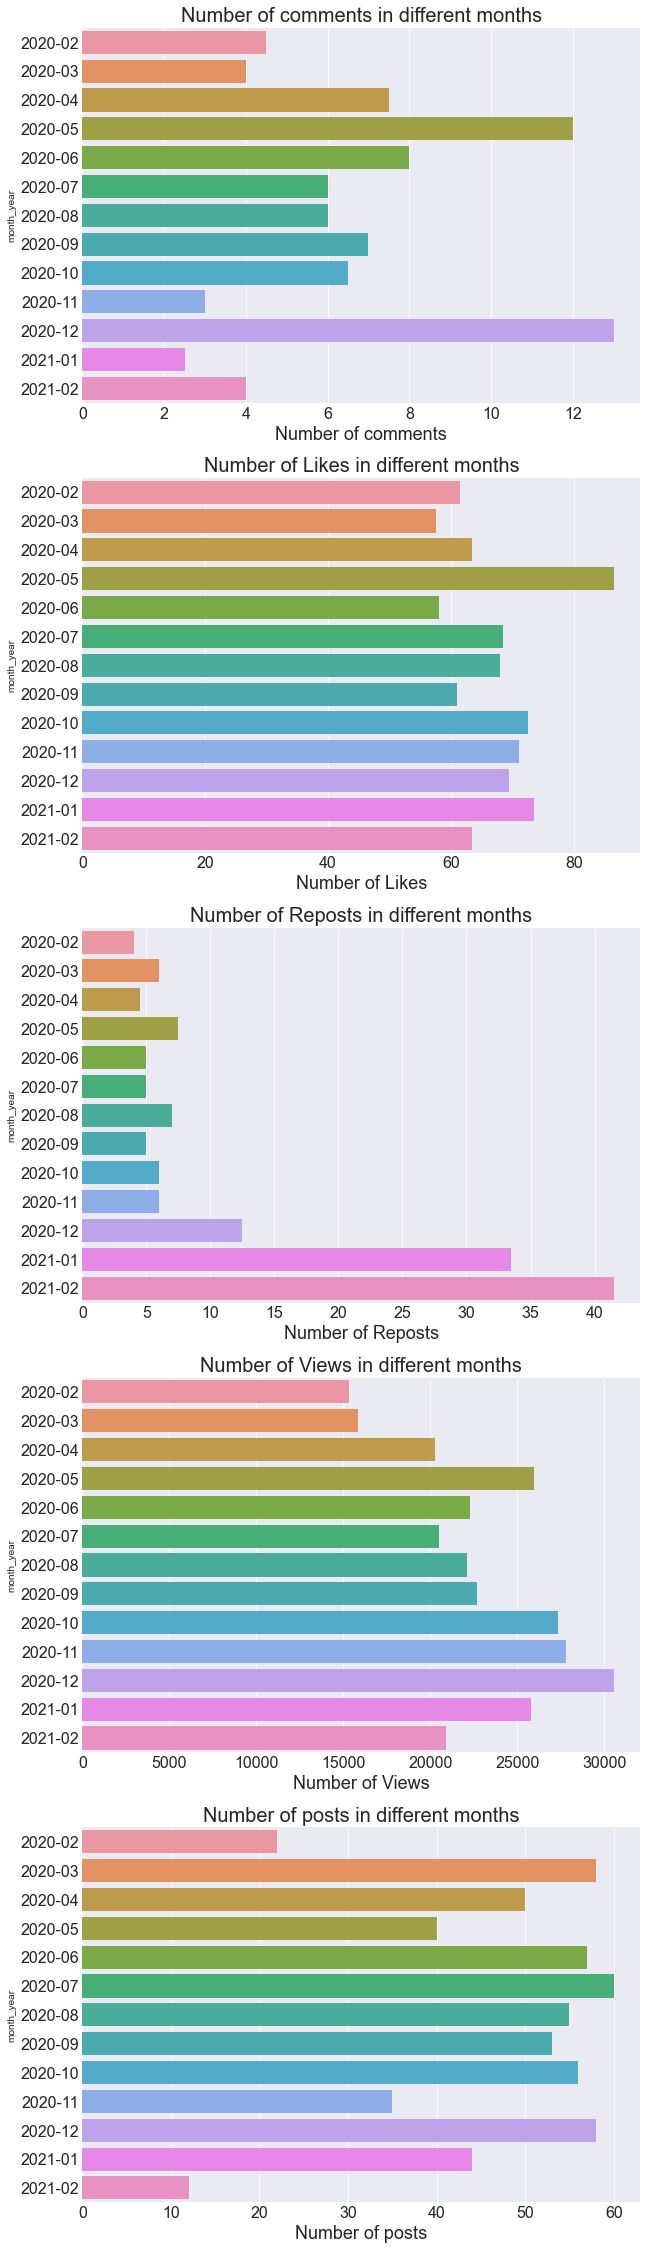

In [819]:
lines_list = ['Number of comments','Number of Likes','Number of Reposts','Number of Views']
i = 0

data_month = df.groupby('month_year').median()

fig,axes=plt.subplots(5, 1, figsize=(10,40))
for row in range(4):
    sns.barplot(y=data_month.index, x=data_month[lines_list[i]], ax=axes[i])
    axes[i].set_title(lines_list[i]+' in different months', fontsize=20)
    axes[i].set_xlabel(lines_list[i], fontsize=18)
    axes[i].tick_params(labelsize=16)
    i += 1
post_counts = df.groupby('month_year').count()
sns.barplot(y=post_counts.index, x=post_counts['id'], ax=axes[4])
axes[4].set_title('Number of posts in different months', fontsize=20)
axes[4].set_xlabel('Number of posts', fontsize=18)
axes[4].tick_params(labelsize=16)

Так как февраль еще только началася, то данные за февраль ничего не показывают.\
Видно, что в январе было меньше постов, а так же было резкое падение постов в ноябре.\
Последние пол года число просмотров непрерывно росло и остановилось перед новым годом.\
Число лайков всегда находится примерно на одном уровне.\
Также есть тенденция на снижение просмотров в летний период, что объянимо отпусками и каникулами у студентов\
Также есть резкий рост репостов в последние два месяца, что возможно объясняется новыми рубриками, это будет рассмотренно дальше\
Также есть два пика роста лайков в декабре и мае\
Росты велечин в апреле и мае могут объясняться введением карантина по всей стране и активной рекламной кампанией компании Skillbox\

Для более точного анализа нужно посмотреть средние велечины на пост за каждый месяц.

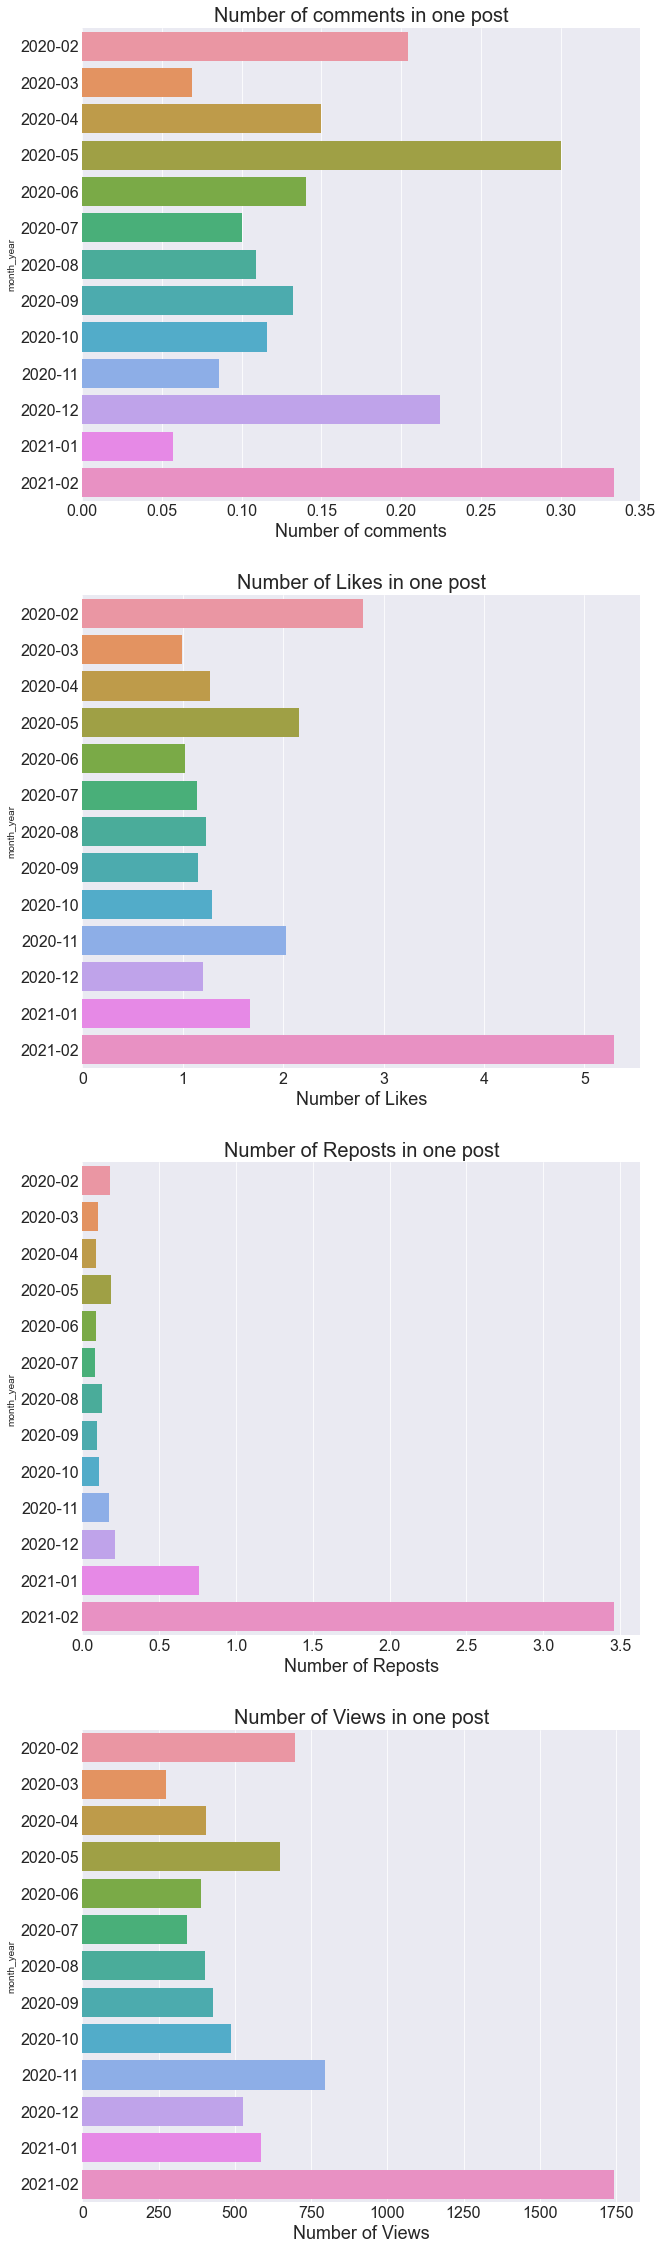

In [827]:
i = 0
fig,axes=plt.subplots(4, 1, figsize=(10,40))
for row in range(4):
    sns.barplot(y=data_month.index, x=data_month[lines_list[i]] / post_counts[lines_list[i]], ax=axes[i])
    axes[i].set_title(lines_list[i]+' in one post', fontsize=20)
    axes[i].set_xlabel(lines_list[i], fontsize=18)
    axes[i].tick_params(labelsize=16)
    i += 1

Так же наблюдается резкий рост репостов в январе, но в тоже время есть падение лайков в январе.\
Также есть рост просмотров в ноябре. 

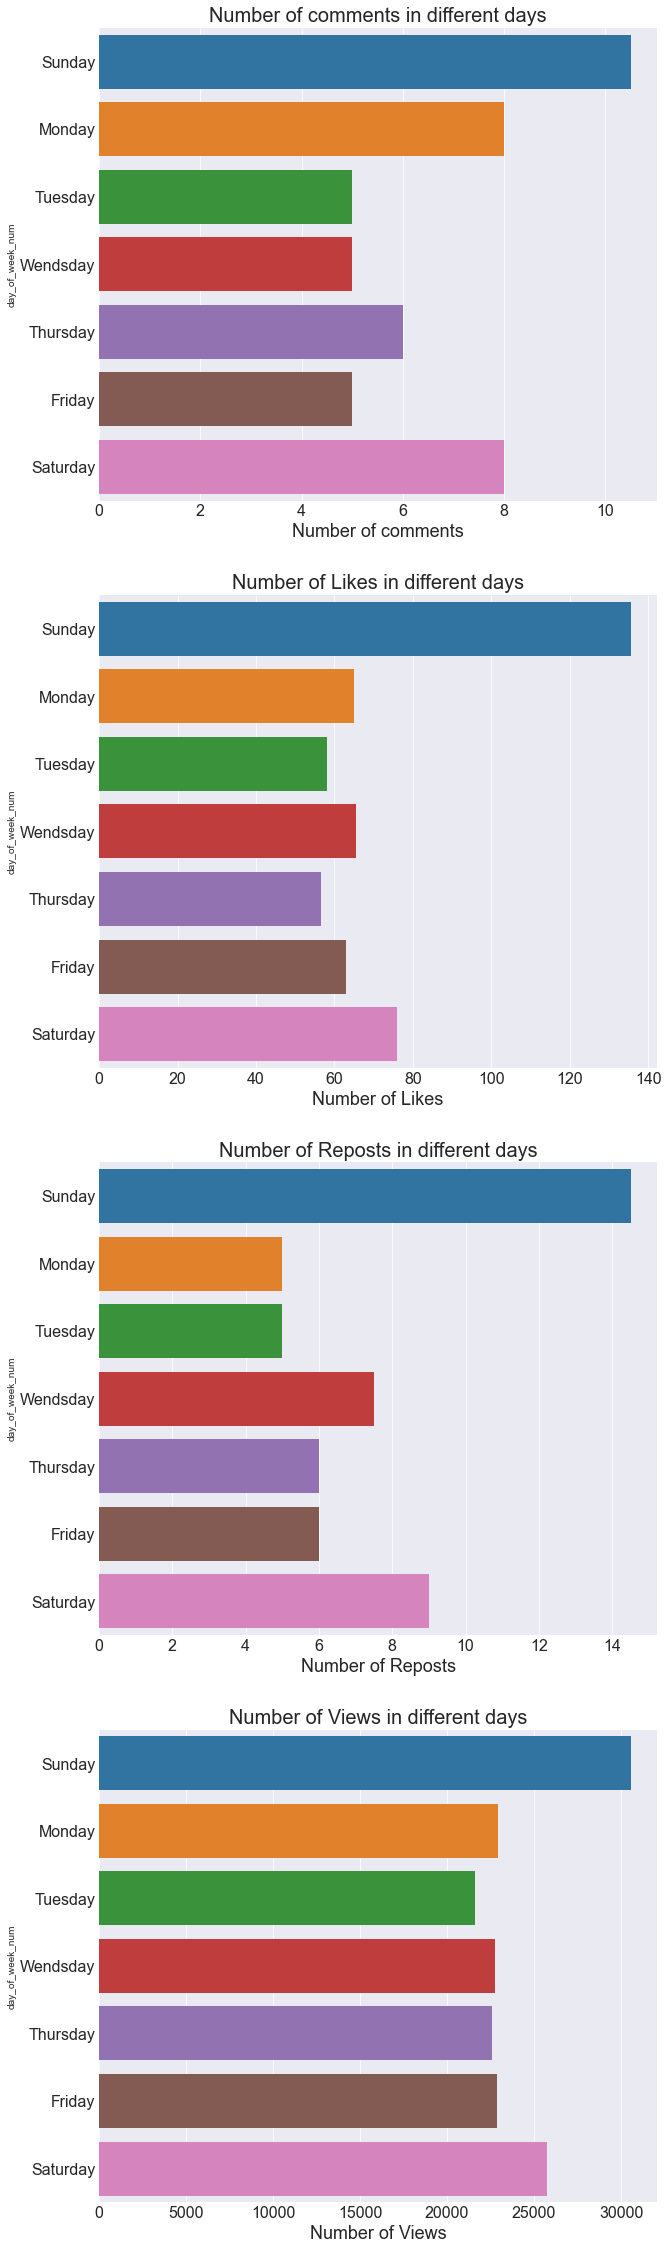

In [846]:
i = 0
data_days = df.groupby('day_of_week_num').median()

fig,axes=plt.subplots(4, 1, figsize=(10,40))
for row in range(4):
    sns.barplot(y=data_days.index, x=data_days[lines_list[i]], ax=axes[i])
    axes[i].set_title(lines_list[i]+' in different days', fontsize=20)
    axes[i].set_xlabel(lines_list[i], fontsize=18)
    axes[i].set_yticklabels(['Sunday','Monday','Tuesday','Wendsday','Thursday', 'Friday','Saturday','Sunday'])
    axes[i].tick_params(labelsize=16)
    i += 1

Самое большое число взаимодействий по всем параметрам происходит в воскресенье. Меньшее число коментариев и репостов меньше всего в рабочие дни.

In [16]:
df.head()

,id,date,text,Number of comments,Number of Likes,Number of Reposts,Number of Views,month_year,day_of_week,day_of_week_num
0,147794,2021-02-09 21:32:41,Учиться на своих ошибках — хорошо. А еще лучше...,5,28,25,5339,2021-02,Tuesday,2
1,147695,2021-02-09 01:42:33,"Оказывается, 75% времени при создании программ...",0,29,14,11202,2021-02,Tuesday,2
2,147680,2021-02-08 22:39:20,9 февраля в 19:00 состоится открытое интервью...,8,21,1,12218,2021-02,Monday,1
3,147581,2021-02-08 19:05:24,Привет! На этой неделе расскажем о тонкостях п...,1,31,23,13397,2021-02,Monday,1
4,147469,2021-02-07 19:07:44,"Кадры, от которых сильнее бьется сердце.\n\nФо...",9,208,68,34325,2021-02,Sunday,0


In [25]:
def find_hashtags(text):
    reg_expr = r'#\w+'
    reg_expr_compiled = re.compile(reg_expr)
    res = reg_expr_compiled.findall(text)
    return res

df['hashtags'] = df['text'].apply(lambda x: find_hashtags(x))
df

,id,date,text,Number of comments,Number of Likes,Number of Reposts,Number of Views,month_year,day_of_week,day_of_week_num,hashtags
0,147794,2021-02-09 21:32:41,Учиться на своих ошибках — хорошо. А еще лучше...,5,28,25,5339,2021-02,Tuesday,2,"[#Skillbox_дизайн, #В_закладки_Skillbox]"
1,147695,2021-02-09 01:42:33,"Оказывается, 75% времени при создании программ...",0,29,14,11202,2021-02,Tuesday,2,"[#skillbox_программирование, #статья_skillbox]"
2,147680,2021-02-08 22:39:20,9 февраля в 19:00 состоится открытое интервью...,8,21,1,12218,2021-02,Monday,1,[#Skillbox_Ruarts]
3,147581,2021-02-08 19:05:24,Привет! На этой неделе расскажем о тонкостях п...,1,31,23,13397,2021-02,Monday,1,[#Расписание_Skillbox]
4,147469,2021-02-07 19:07:44,"Кадры, от которых сильнее бьется сердце.\n\nФо...",9,208,68,34325,2021-02,Sunday,0,"[#Skillbox_вдохновляет, #Иллюстрация_Skillbox,..."
...,...,...,...,...,...,...,...,...,...,...,...
95,51961,2020-02-21 19:20:45,Слышали про метод шести шляп? Это крайне полез...,0,485,70,62236,2020-02,Friday,5,"[#В_закладки_Skillbox, #Skillbox_маркетинг]"
96,51954,2020-02-21 00:40:42,"Помните, как в детстве было сложно читать книж...",5,128,26,15995,2020-02,Friday,5,"[#Статья_Skillbox, #Skillbox_дизайн]"
97,51946,2020-02-20 19:00:05,"Вы удивитесь, но «Тому и Джерри» уже 80 лет!\n...",7,66,5,19203,2020-02,Thursday,4,[#В_закладки_Skillbox]
98,51940,2020-02-20 02:58:26,Настало время подвести итоги конкурса дизайна ...,4,51,3,13528,2020-02,Thursday,4,[#Конкурс_Skillbox]


In [55]:
df = df.explode('hashtags')
df.head()

,id,date,text,Number of comments,Number of Likes,Number of Reposts,Number of Views,month_year,day_of_week,day_of_week_num,hashtags
0,147794,2021-02-09 21:32:41,Учиться на своих ошибках — хорошо. А еще лучше...,5,28,25,5339,2021-02,Tuesday,2,#Skillbox_дизайн
0,147794,2021-02-09 21:32:41,Учиться на своих ошибках — хорошо. А еще лучше...,5,28,25,5339,2021-02,Tuesday,2,#В_закладки_Skillbox
1,147695,2021-02-09 01:42:33,"Оказывается, 75% времени при создании программ...",0,29,14,11202,2021-02,Tuesday,2,#skillbox_программирование
1,147695,2021-02-09 01:42:33,"Оказывается, 75% времени при создании программ...",0,29,14,11202,2021-02,Tuesday,2,#статья_skillbox
2,147680,2021-02-08 22:39:20,9 февраля в 19:00 состоится открытое интервью...,8,21,1,12218,2021-02,Monday,1,#Skillbox_Ruarts


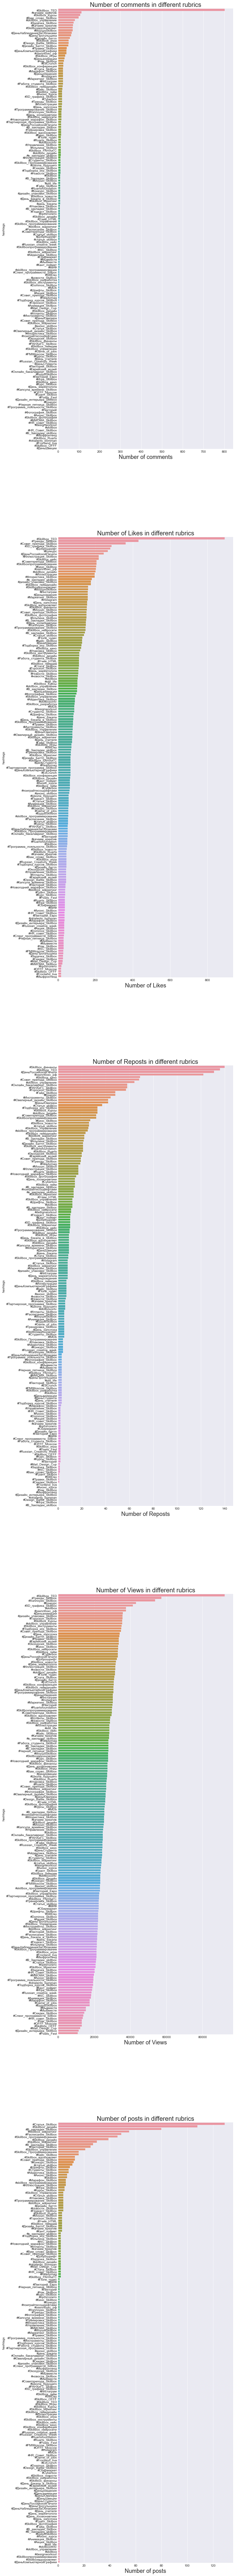

In [71]:
i = 0
fig,axes=plt.subplots(5, 1, figsize=(10,150))
for row in range(4):
    data_hashtags = df.groupby('hashtags').median().sort_values(lines_list[i], ascending=False)
    sns.barplot(y=data_hashtags.index, x=data_hashtags[lines_list[i]], ax=axes[i])
    axes[i].set_title(lines_list[i]+' in different rubrics', fontsize=20)
    axes[i].set_xlabel(lines_list[i], fontsize=18)
    axes[i].tick_params(labelsize=10)
    i += 1
hashtag_counts = df.groupby('hashtags').count().sort_values('id', ascending=False)
sns.barplot(y=hashtag_counts.index, x=hashtag_counts['id'], ax=axes[4])
axes[4].set_title('Number of posts in different rubrics', fontsize=20)
axes[4].set_xlabel('Number of posts', fontsize=18)
axes[4].tick_params(labelsize=10)

Самая популярная статья по количеству лайков, комментариев и репостов это #Skillbox_TED, нужно исследовать ее поподробнее

In [84]:
print(str(df.loc[df['hashtags']=='#Skillbox_TED']['text'].unique()))
df.loc[df['hashtags']=='#Skillbox_TED']

['[club163456906|TEDxDvortsovayaSquare] и Skillbox ищут победителя! Для него мы приготовили целый комплект призов. По порядку: \n\n⚡ Сертификат на любой курс Skillbox;\n⚡ Онлайн-сессия о внутренней кухне конференции с организатором TEDxDS;\n⚡ Книга «TED TALKS. Слова меняют мир. Первое официальное руководство по публичным выступлениям» от куратора и постоянного ведущего TED Криса Андерсона;\n⚡ Брендированная сумка TEDxDS.\n\nКак видите, есть за что побороться!\n\nЧтобы все это выиграть, готовить речь для выступления не надо. Все гораздо проще:\n\n1. Поставьте лайк этому посту.\n2. Отметьте в комментариях друга.\n3. Поделитесь этим постом у себя в ленте.\n\nПобедителя объявим 15 мая!\nЖелаем удачи 😉\n\n#Конкурс_Skillbox #Skillbox_TED']


,id,date,text,Number of comments,Number of Likes,Number of Reposts,Number of Views,month_year,day_of_week,day_of_week_num,hashtags
56,60637,2020-05-13 23:32:38,[club163456906|TEDxDvortsovayaSquare] и Skillb...,802,893,136,92243,2020-05,Wednesday,3,#Skillbox_TED


Данный пост является розыгрышом, что обьясняет аномальное количество лайков, комментариев и репостов в мае месяце. В дальнейшем этот пост можно исключить из выборки. Также можно убрать из выборки посты, число которых равняется одному.

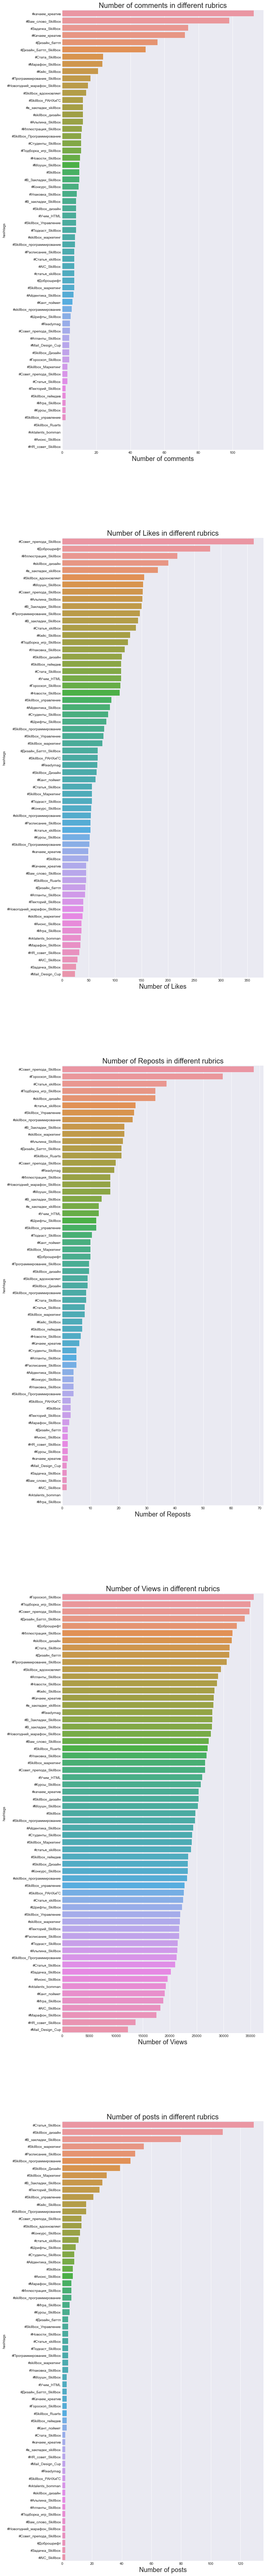

In [130]:
i = 0
fig,axes=plt.subplots(5, 1, figsize=(10,130))
popular_rubrics = list((df['hashtags'].value_counts() > 1).loc[(df['hashtags'].value_counts() > 1) == True].index)
for row in range(4):
    data_hashtags = df.loc[(df['hashtags'] != '#Skillbox_TED') & (df['hashtags'].isin(popular_rubrics) == True)].\
    groupby('hashtags').median().sort_values(lines_list[i], ascending=False)
    sns.barplot(y=data_hashtags.index, x=data_hashtags[lines_list[i]], ax=axes[i])
    axes[i].set_title(lines_list[i]+' in different rubrics', fontsize=20)
    axes[i].set_xlabel(lines_list[i], fontsize=18)
    axes[i].tick_params(labelsize=10)
    i += 1
hashtag_counts = df.loc[(df['hashtags'] != '#Skillbox_TED') & (df['hashtags'].isin(popular_rubrics) == True)].\
groupby('hashtags').count().sort_values('id', ascending=False)
sns.barplot(y=hashtag_counts.index, x=hashtag_counts['id'], ax=axes[4])
axes[4].set_title('Number of posts in different rubrics', fontsize=20)
axes[4].set_xlabel('Number of posts', fontsize=18)
axes[4].tick_params(labelsize=10)

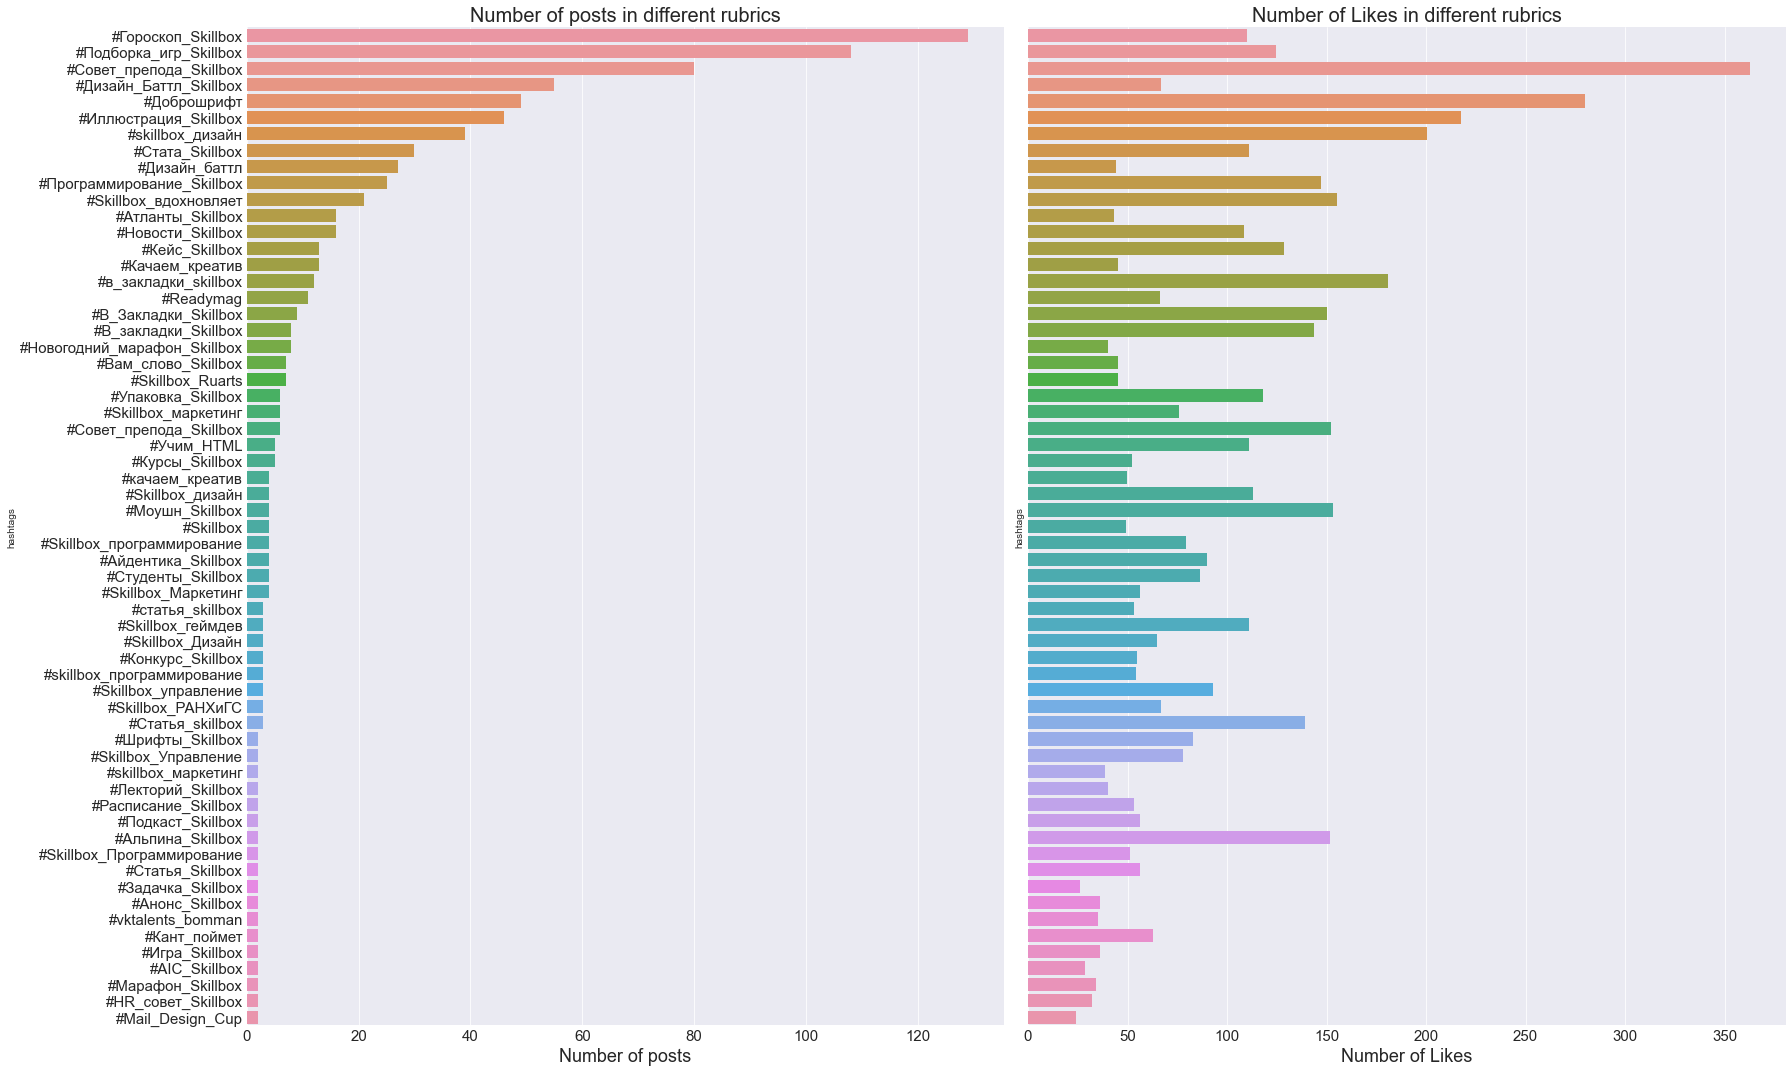

In [136]:
fig,axes=plt.subplots(1, 2, sharey=True, figsize=(25,15))


sns.barplot(y=hashtag_counts.index, x=hashtag_counts['id'], ax=axes[0])
axes[0].set_title('Number of posts in different rubrics', fontsize=20)
axes[0].set_xlabel('Number of posts', fontsize=18)
axes[0].tick_params(labelsize=15)

sns.barplot(y=data_hashtags.index, x=data_hashtags['Number of Likes'], ax=axes[1])
axes[1].set_title("Number of Likes in different rubrics", fontsize=20)
axes[1].set_xlabel('Number of Likes', fontsize=18)
axes[1].tick_params(labelsize=15)

plt.tight_layout()
plt.show()

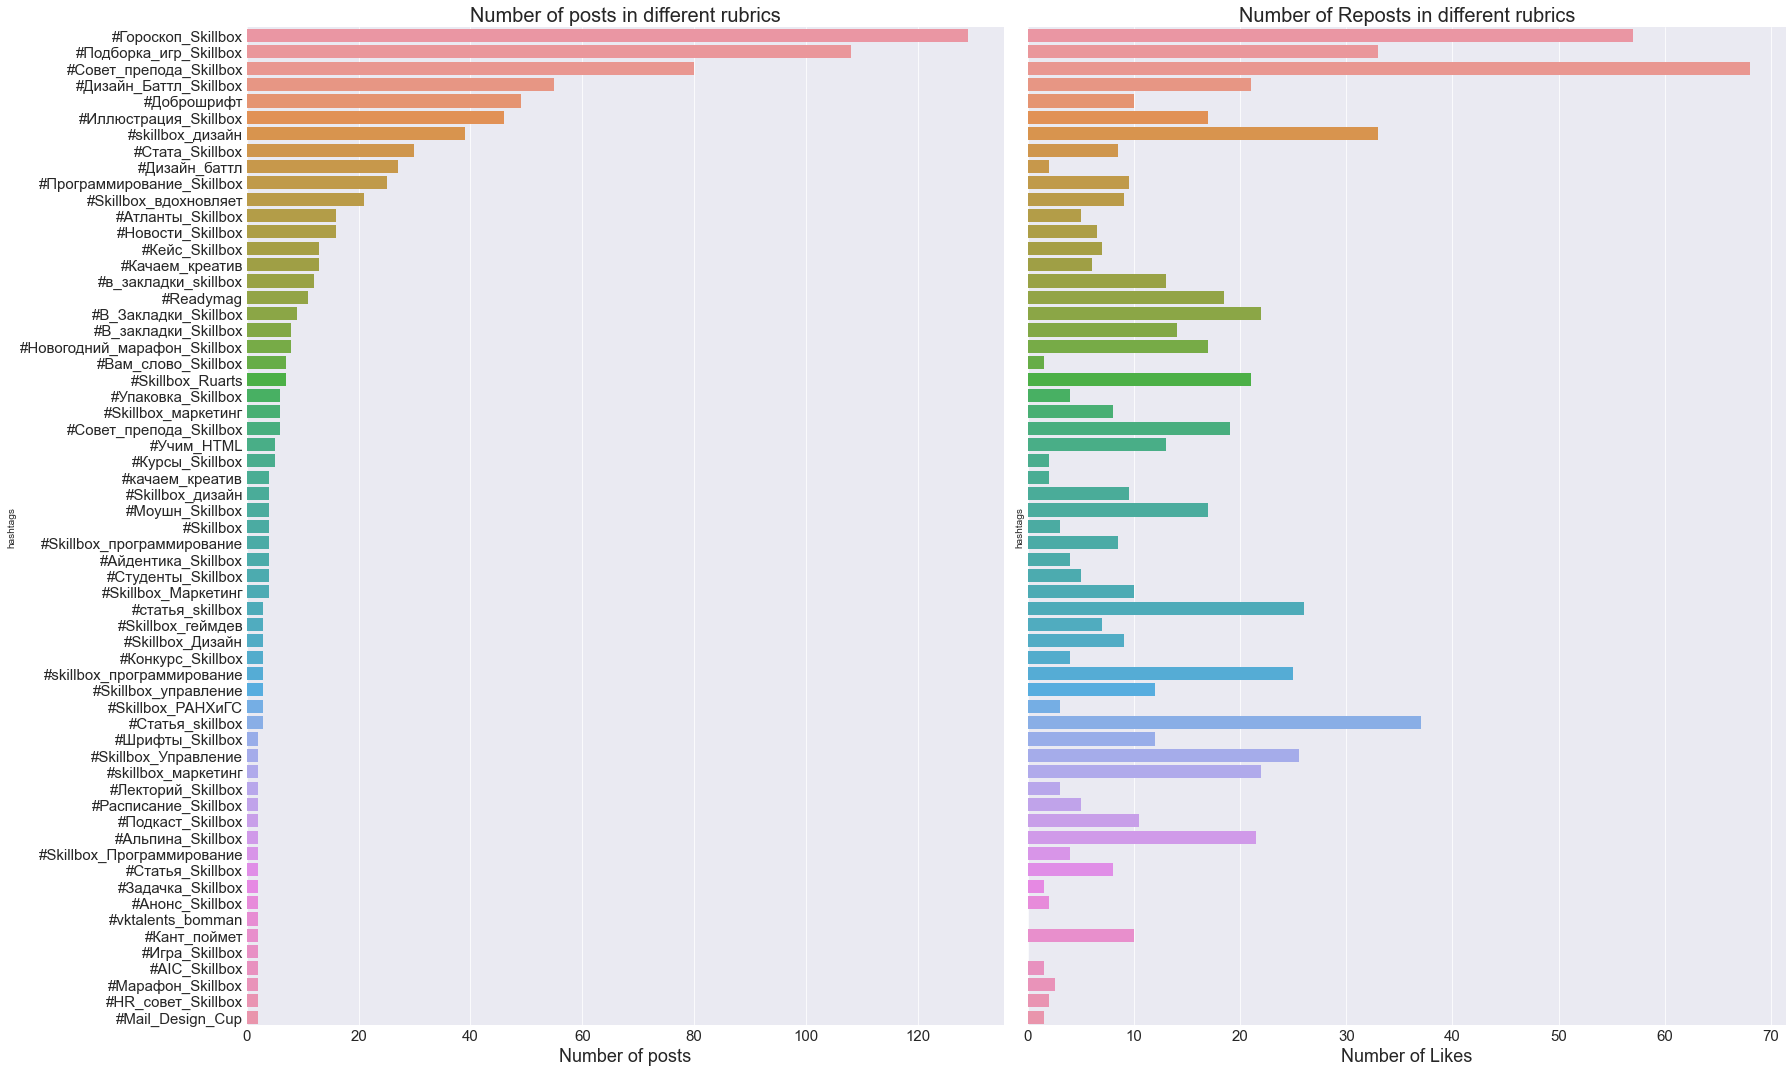

In [137]:
fig,axes=plt.subplots(1, 2, sharey=True, figsize=(25,15))

sns.barplot(y=hashtag_counts.index, x=hashtag_counts['id'], ax=axes[0])
axes[0].set_title('Number of posts in different rubrics', fontsize=20)
axes[0].set_xlabel('Number of posts', fontsize=18)
axes[0].tick_params(labelsize=15)

sns.barplot(y=data_hashtags.index, x=data_hashtags['Number of Reposts'], ax=axes[1])
axes[1].set_title("Number of Reposts in different rubrics", fontsize=20)
axes[1].set_xlabel('Number of Likes', fontsize=18)
axes[1].tick_params(labelsize=15)

plt.tight_layout()
plt.show()

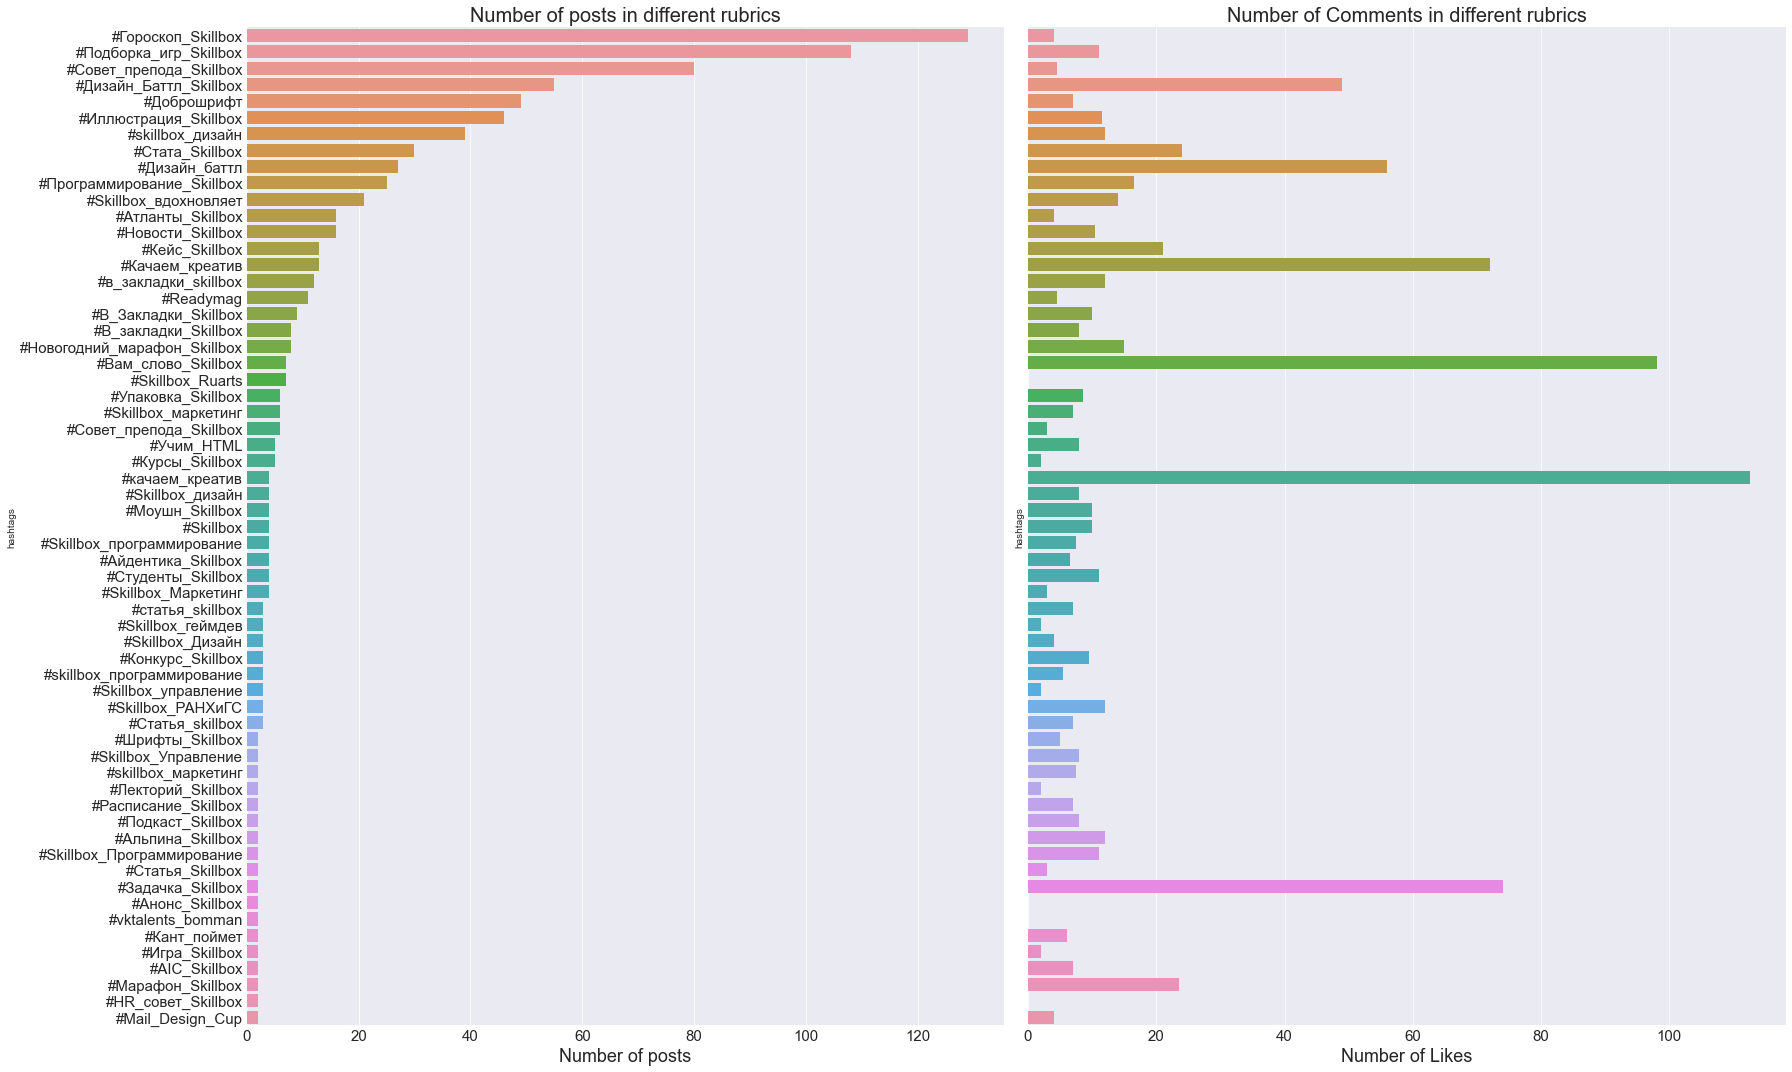

In [139]:
fig,axes=plt.subplots(1, 2, sharey=True, figsize=(25,15))

sns.barplot(y=hashtag_counts.index, x=hashtag_counts['id'], ax=axes[0])
axes[0].set_title('Number of posts in different rubrics', fontsize=20)
axes[0].set_xlabel('Number of posts', fontsize=18)
axes[0].tick_params(labelsize=15)

sns.barplot(y=data_hashtags.index, x=data_hashtags['Number of comments'], ax=axes[1])
axes[1].set_title("Number of Comments in different rubrics", fontsize=20)
axes[1].set_xlabel('Number of Likes', fontsize=18)
axes[1].tick_params(labelsize=15)

plt.tight_layout()
plt.show()

Из графиков видно, что рубрики Альпина, Совет препода, Задачка, Качаем креатив, Вам слово, Маркетинг, Програмирование имеют большую активность аудитории, но количество постов по эти рубрикам низкое. Можно увеличить количество постов в этих рубриках

В дизайн батле очень низкое количесвто репостов и лайков, но количество постов высокое, можно уменьшить количество данных постов и заменить их другими.